<a href="https://colab.research.google.com/github/kareem1925/Ismailia-school-of-AI/blob/master/machine%20learning%20for%20classifying%20quantum%20states/Qiskit%20code%20for%20learning%20Q%20states.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Notebook configration

**Important**
Due to an error in the while loop of the AQGD optimizer in Qiskit-Aqua version 0.6.4, I have a separate repo for solving it and also I have updated the returned values to include the history of the loss function so that we can plot it.
The following two cells must be run sequentially.

In [1]:
!pip install git+https://github.com/kareem1925/qiskit-aqua.git@kareem1925-mentor 

  Cloning https://github.com/kareem1925/qiskit-aqua.git (to revision kareem1925-mentor) to /tmp/pip-req-build-vmp3xf8c
  Running command git clone -q https://github.com/kareem1925/qiskit-aqua.git /tmp/pip-req-build-vmp3xf8c
  Running command git checkout -b kareem1925-mentor --track origin/kareem1925-mentor
  Switched to a new branch 'kareem1925-mentor'
  Branch 'kareem1925-mentor' set up to track remote branch 'kareem1925-mentor' from 'origin'.
     |████████████████████████████████| 2.9MB 2.8MB/s 
     |████████████████████████████████| 102kB 12.4MB/s 
     |████████████████████████████████| 5.6MB 21.2MB/s 
     |████████████████████████████████| 573kB 39.3MB/s 
     |████████████████████████████████| 24.3MB 28.9MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 51kB 10.1MB/s 
  Created wheel for qiskit-aqua: filename=qiskit_aqua-0.7.0-cp36-none-any.whl size=1740668 sha256=c0819967289d72b641d9c532b1f0cf57bb3b4b658d2281ffc53ed9a626ec6b3

In [2]:
!pip install qiskit-aer qiskit-ignis qiskit-terra qiskit-ibmq-provider -q

     |████████████████████████████████| 23.1MB 132kB/s 
     |████████████████████████████████| 143kB 58.9MB/s 
     |████████████████████████████████| 153kB 59.8MB/s 
     |████████████████████████████████| 71kB 12.0MB/s 
     |████████████████████████████████| 51kB 9.2MB/s 
     |████████████████████████████████| 2.3MB 73.5MB/s 


In [0]:
import numpy as np
from qiskit import *
from qiskit import Aer
from qiskit.aqua.components.optimizers import *
from qiskit.quantum_info import state_fidelity
from qiskit.quantum_info.analysis import average_data,hellinger_fidelity
from qiskit.providers.aer.noise import NoiseModel
from qiskit.aqua.utils import get_subsystem_density_matrix
from qiskit.tools.visualization import plot_histogram
import matplotlib.pyplot as plt

np.set_printoptions(precision=15)
%matplotlib inline

In [65]:
plt.style.use("ggplot")

import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright


### Quantum Device selection
I've chosen IBM Vigo quantum computer to be the main backend. To run the following cell please get your tokken from IBMQ dashboard.

In [5]:
IBMQ.save_account('', overwrite=True)
provider = IBMQ.load_account()
#provider.backends()
device_backend = provider.get_backend('ibmq_vigo')
noise_model = NoiseModel.from_backend(device_backend)
coupling_map = device_backend.configuration().coupling_map
basis_gates = noise_model.basis_gates
print(noise_model)
# Select the QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['id', 'u2', 'cx', 'u3', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('cx', [0, 1]), ('cx', [1, 0]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 1]), ('cx', [3, 1]), ('cx', [3, 4]), ('cx', [4, 3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]


### Circuit Preparation

As I've shown in the [Pennylane notebook](https://github.com/kareem1925/Ismailia-school-of-AI/blob/master/machine%20learning%20for%20classifying%20quantum%20states/pennylane-quantum-state-learning.ipynb), I've initalized the same circuit in Qiskit. I only included a noisy backend with its properties and a snapshot to get the statevector. This means that the number of shots won't affect the the statevector unlike the counts measurements which are affected by it. We use one the utils in qiskit to get the density matrix of the first and second qubits only.

In [0]:

def circuit(params,shots):
    
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    qc = QuantumCircuit(q,c)
    #qc.h(q[0])
    
    qc.ry(params[0],q[0])
#    qc.rx(params[1],q[0])
#    qc.ry(params[2],q[0])
#    qc.rx(params[1],q[0])
    
    qc.cx(q[0],q[1])
    qc.snapshot('0')
    qc.measure(q[0],c[0])
    qc.measure(q[1],c[1])
    job = execute(qc, simulator, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates,shots=shots,backend_options={"max_parallel_threads":10},optimization_level=3).result()
    
    statevector = np.array(job.data()['snapshots']['statevector']['0'][0])
    statevector = get_subsystem_density_matrix(statevector,[2,3,4])
    counts = job.get_counts()
    return counts, statevector


### Define cost function
we can use the cost function through $3$ ways:


1.   Fiddelity measurement.
2.   Count measurement difference.
3.   average_data function which mimics the Hermitian measurement in Pennylane.



In [0]:
# for count difference in the cost function
labels = np.array([0.5,0,0,0.5])

labels_vector = np.array([1/np.sqrt(2),0,0,1/np.sqrt(2)])


#metric = 'vectorstate'
metric = 'average_data'
def cost_vec(var):
    st_vec = circuit(var,1000)[1]
    return abs(1 - state_fidelity(st_vec,labels_vector))

def cost_count100(var):
    st_vec = circuit(var,100)[0]
    return  -average_data(st_vec,{"00":1, "01":0, "10":0, "11":1})

def cost_count10(var):
    st_vec = circuit(var,10)[0]
    return  -average_data(st_vec,{"00":1, "01":0, "10":0, "11":1})

def cost_count1000(var):
    st_vec = circuit(var,1000)[0]
    return  -average_data(st_vec,{"00":1, "01":0, "10":0, "11":1})

def cost_count1(var):
    st_vec = circuit(var,1)[0]
    return  -average_data(st_vec,{"00":1, "01":0, "10":0, "11":1})

 #   else:
  #    co = np.zeros(4)
        
   #   if '00' in st_vec[0].keys():
     #   co[0] = st_vec[0]['00']
    #  if '11' in st_vec[0].keys():
       # co[3] = st_vec[0]['11']
      #if '10' in st_vec[0].keys():
        #co[2] = st_vec[0]['10']
      #if '01' in st_vec[0].keys():
       # co[1] = st_vec[0]['01']

      #return (abs(labels - co/shots)).mean()

In [399]:
# weight initialization
np.random.seed(20)
init_params = np.random.rand(1)
#init_params = [1.57079633]
print(init_params)
print(cost_vec(init_params))

[0.588130801077274]
0.2225965707704386


### Training
the data parameter is a list which contains:


1.   The final best weights.
2.   The value of the cost function.
3.   The number of last iteration.
4.   The history of the cost funciton to be plotted. "*I added this in the main code*"


Testing state vector logic

In [332]:
opt = AQGD(disp=True,maxiter=500,tol=1e-17)
data = opt.optimize(objective_function=cost_vec,num_vars=1,initial_point=init_params)

Iteration: 0 	| Energy: 0.2225965707704386
Iteration: 1 	| Energy: 0.0005448655801651991
Iteration: 2 	| Energy: 0.12010279019547865
Iteration: 3 	| Energy: 0.07172049371268607
Iteration: 4 	| Energy: 0.0065869580967996555
Iteration: 5 	| Energy: 0.06339344262534208
Iteration: 6 	| Energy: 0.0121265368623249
Iteration: 7 	| Energy: 0.014550354842057134
Iteration: 8 	| Energy: 0.02527386767148765
Iteration: 9 	| Energy: 0.00014716657275293255
Iteration: 10 	| Energy: 0.012526687982597151
Iteration: 11 	| Energy: 0.006426679017094816
Iteration: 12 	| Energy: 0.0011267351762527245
Iteration: 13 	| Energy: 0.006579144294567962
Iteration: 14 	| Energy: 0.000674385191892668
Iteration: 15 	| Energy: 0.00199277119621466
Iteration: 16 	| Energy: 0.002250306963876514
Iteration: 17 	| Energy: 1.4076367247373156e-05
Iteration: 18 	| Energy: 0.0014384769828521549
Iteration: 19 	| Energy: 0.00043830507620201686
Iteration: 20 	| Energy: 0.0002358985695321003
Iteration: 21 	| Energy: 0.000640227278053

In [333]:
data[:3]

(array([1.570796314249988]), 2.220446049250313e-16, 323)

counts {'11': 469, '10': 22, '00': 487, '01': 22}


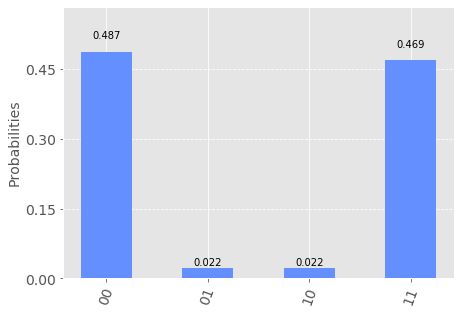

In [0]:
counts,density_matrix = circuit(data[0],1000)
print('counts', counts)
plot_histogram(counts)

In [0]:
print("state fidelity: ", state_fidelity(density_matrix,labels_vector))

state fidelity:  0.9999999999999998


### Testing Count measurement

**Quantum Gradients**

We can also compute the gradients ourselves and implement any gradient optimization technique.
[Quantum gradients](https://arxiv.org/abs/1811.11184) can be computed by the following equation:

\begin{align}
  \frac{df}{d\theta }\,=\,\frac{1}{2}\,\left( f\left( \theta +\frac{\pi }{2} \right)-f\left( \theta -\frac{\pi }{2} \right) \right)\\ \\
\end{align}

where $\theta$ is the weights and $f$ is quantum unitary gate.

In [0]:
def gradient(params,cost):
    g = np.zeros(len(params))

    for id,i in enumerate(params):
      params[id] = params[id] + np.pi/2
      f1 = cost(params)
      params[id] = params[id] - np.pi
      f2 = cost(params)
      params[id] = params[id] + np.pi/2
      g[id] = (f1-f2)/2

    return g

In [0]:
def optimize(params,lr,cost):
    """

    this fucntion controls SGD by computing the gradients and updating the weights

    """
    g = gradient(params,cost)
    
    new_weights = params - (lr*g)
    
    return new_weights

**10 shots**

In [387]:

epochs = 400
params = init_params
loss = np.inf
hist = []

for it in range(epochs):
  params = optimize(params,lr=0.1,cost=cost_count10)
  temp = cost_count10(params)
  if temp < loss:
    best = params
    loss = temp
  hist.append(temp)
  if it % 10 == 0:
    print(temp)

-1.0
-1.0
-0.8999999999999999
-1.0
-0.8
-1.0
-0.8999999999999999
-1.0
-1.0
-1.0
-1.0
-0.8999999999999999
-1.0
-1.0
-1.0
-0.8999999999999999
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-0.8999999999999999
-1.0
-0.9
-0.8999999999999999
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-0.9
-0.9


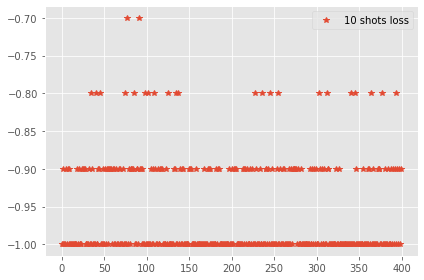

In [388]:
plt.plot(hist,"*", label="10 shots loss")
plt.tight_layout()
plt.legend()

counts {'11': 6, '00': 4}


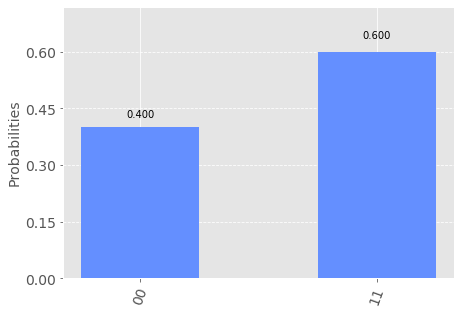

In [389]:
counts,density_matrix = circuit(best,10)
print('counts', counts)
plot_histogram(counts)

In [390]:
print("state fidelity: ", state_fidelity(density_matrix,labels_vector))

state fidelity:  0.9145973769270366


**100 shots**

In [381]:

epochs = 400
params = init_params
loss = np.inf
hist = []

for it in range(epochs):
  params = optimize(params,lr=0.1,cost=cost_count100)
  temp = cost_count100(params)
  if temp < loss:
    best = params
    loss = temp
  hist.append(temp)
  if it % 10 == 0:
    print(temp)

-0.95
-0.97
-0.96
-0.97
-0.97
-0.94
-0.94
-0.95
-0.9500000000000001
-0.9199999999999999
-0.94
-0.97
-0.96
-0.97
-0.91
-0.97
-0.94
-0.94
-0.96
-0.99
-0.95
-0.98
-0.95
-0.92
-0.99
-0.9600000000000001
-0.98
-0.95
-0.96
-0.96
-0.95
-0.94
-0.96
-0.94
-0.96
-0.97
-0.97
-0.96
-0.96
-0.9299999999999999


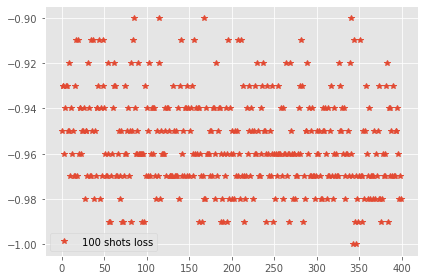

In [382]:
plt.plot(hist,"*", label="100 shots loss")
plt.tight_layout()
plt.legend()

counts {'11': 52, '10': 3, '00': 43, '01': 2}


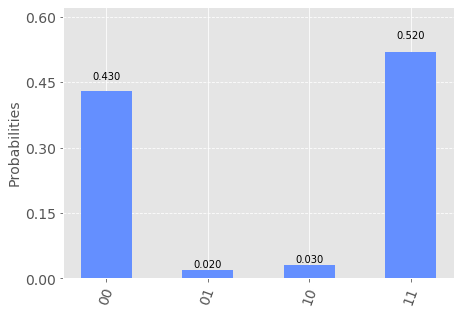

In [384]:
counts,density_matrix = circuit(best,100)
print('counts', counts)
plot_histogram(counts)

In [385]:
print("state fidelity: ", state_fidelity(density_matrix,labels_vector))

state fidelity:  0.9999946389299257


**1000 shots**

In [391]:

epochs = 400
params = init_params
loss = np.inf
hist = []

for it in range(epochs):
  params = optimize(params,lr=0.1,cost=cost_count1000)
  temp = cost_count1000(params)
  if temp < loss:
    best = params
    loss = temp
  hist.append(temp)
  if it % 10 == 0:
    print(temp)

-0.942
-0.955
-0.9359999999999999
-0.945
-0.949
-0.944
-0.9500000000000001
-0.9420000000000001
-0.9580000000000001
-0.958
-0.9570000000000001
-0.96
-0.9630000000000001
-0.9450000000000001
-0.95
-0.955
-0.952
-0.95
-0.958
-0.959
-0.951
-0.953
-0.9530000000000001
-0.958
-0.946
-0.956
-0.96
-0.956
-0.958
-0.9550000000000001
-0.9550000000000001
-0.952
-0.952
-0.965
-0.96
-0.9530000000000001
-0.9570000000000001
-0.968
-0.9690000000000001
-0.9570000000000001


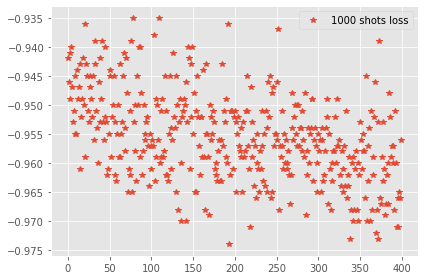

In [392]:
plt.plot(hist,"*", label="1000 shots loss")
plt.tight_layout()
plt.legend()

counts {'11': 588, '10': 22, '00': 367, '01': 23}


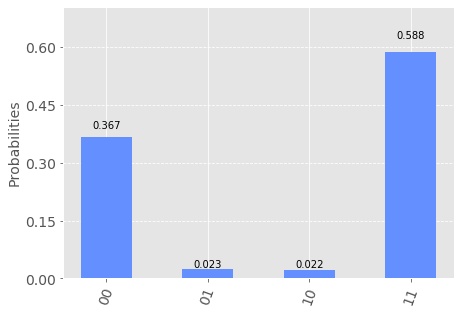

In [393]:
counts,density_matrix = circuit(best,1000)
print('counts', counts)
plot_histogram(counts)

In [394]:
print("state fidelity: ", state_fidelity(density_matrix,labels_vector))

state fidelity:  0.9837140431186004


In [397]:
circuit([-np.pi/2],10000)

({'00': 4896, '01': 173, '10': 214, '11': 4717},
 array([[ 0.5+0.000000000000000e+00j,  0. +0.000000000000000e+00j,
          0. +0.000000000000000e+00j, -0.5-6.123233995736766e-17j],
        [ 0. +0.000000000000000e+00j,  0. +0.000000000000000e+00j,
          0. +0.000000000000000e+00j,  0. +0.000000000000000e+00j],
        [ 0. +0.000000000000000e+00j,  0. +0.000000000000000e+00j,
          0. +0.000000000000000e+00j,  0. +0.000000000000000e+00j],
        [-0.5+6.123233995736766e-17j,  0. +0.000000000000000e+00j,
          0. +0.000000000000000e+00j,  0.5+0.000000000000000e+00j]]))

**1 shot**

In [400]:

epochs = 400
params = init_params
loss = np.inf
hist = []

for it in range(epochs):
  params = optimize(params,lr=0.1,cost=cost_count1)
  temp = cost_count1(params)
  if temp < loss:
    best = params
    loss = temp
  hist.append(temp)
  if it % 10 == 0:
    print(temp)

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-0.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


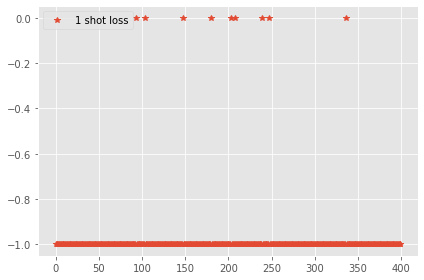

In [401]:
plt.plot(hist,"*", label="1 shot loss")
plt.tight_layout()
plt.legend()

counts {'00': 1}


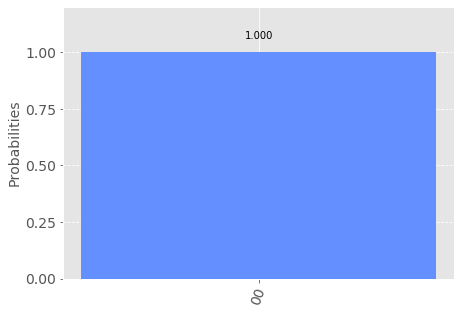

In [402]:
counts,density_matrix = circuit(best,1)
print('counts', counts)
plot_histogram(counts)

In [403]:
print("state fidelity: ", state_fidelity(density_matrix,labels_vector))

state fidelity:  0.7774034292295615
